# Claim Prediction using Julia

In [1]:
include("utils.jl")
using .utils
using Flux, CSV, DataFrames, Statistics 
using Plots, MLJ, ClassImbalance
using MLJ: partition
using Flux: Dense, train!
using ClassImbalance: smote
using YeoJohnson
using CUDA

We load Australian private auto insurance claim data from 2004, sourced from R's 'CASdatasets' package. Original reference: P. De Jong and G.Z. Heller (2008), Generalized linear models for insurance data, Cambridge University Press.

In [2]:
data = DataFrame(CSV.File("../data/ausprivauto0405.csv"))

Row,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
,Float64,Float64,String15,String31,String7,String31,Int64,Int64,Float64
1,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
2,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
3,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
4,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
5,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0
6,0.854209,2.01,old cars,Hardtop,Male,older work. people,0,0,0.0
7,0.854209,1.6,old cars,Panel van,Male,older work. people,0,0,0.0
8,0.555784,1.47,young cars,Hatchback,Male,oldest people,0,0,0.0
9,0.361396,0.52,oldest cars,Hatchback,Female,working people,0,0,0.0


`ClaimOcc` is the target variable, and we create a binary indicator from it and drop `ClaimNb` and `ClaimAmount` as features.

In [3]:
data = select!(data, Not(:ClaimNb));
data = select!(data, Not(:ClaimAmount));

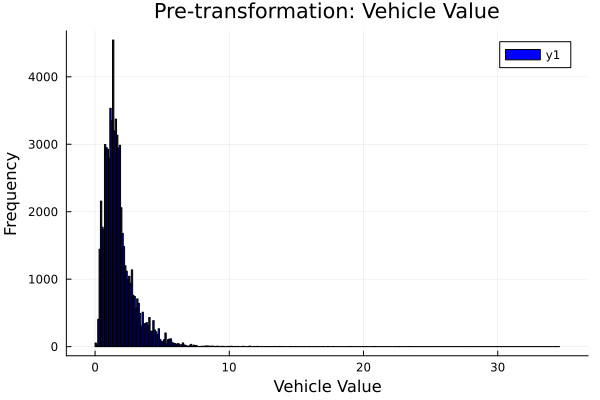

In [4]:
histogram(data[:, :VehValue], xlabel = "Vehicle Value", title = "Pre-transformation: Vehicle Value", 
    ylabel = "Frequency", 
    color = "blue")

We dummy encode our `DataFrame` and transform it into a matrix for Flux to interpret.

In [5]:
#data_encode = Matrix{Float64}(dummyEncodeAll(data));
data_encode = dummyEncodeAll(data);

Below is the correlation matrix (post dummy variable encoding). It indicates that Exposure (row/col 1) has the highest positive correlation with claim occurrence.

In [6]:
cor(Matrix{Float64}(data_encode))

24×24 Matrix{Float64}:
  1.0          -0.000588404   0.0177538   …  -0.0143729     0.13298
 -0.000588404   1.0           0.200778        0.00629752    0.0184379
  0.0177538     0.200778      1.0             0.0123706     0.0175124
  0.0131467    -0.428516     -0.354037       -0.0343922    -0.0147564
 -0.053534      0.392094     -0.267064        0.0338324    -0.00155735
 -0.00880636    0.0366273    -0.04194     …   0.0413284    -0.0122331
  0.00210075    0.416806     -0.0156576      -0.0472632     0.00889231
  0.0145937     0.0337903    -0.0263802       0.00083748    0.00868939
  0.0275381    -0.0259387    -0.0104237       0.0249691     0.00600838
  0.00271413   -0.159731      0.0158743      -0.0525006    -0.00486594
  0.00763741    0.0512821    -0.0248309   …   0.0390562     0.00027578
 -0.0221287     0.0169358    -0.0320623       0.000991552   0.00814576
 -0.00953297   -0.00593678   -0.0430173      -0.0205451    -0.00335137
 -0.000280745   0.0411681    -0.0111427      -0.00704041    0

In [7]:
X = data_encode[:, 1:(end-1)]
y = data_encode[:, end];

Yeo-Johnson transformation is applied to normalise the features (as evident by the post-transformation histogram below).

In [8]:
for c ∈ 1:size(X, 2)
    X[:, c] = yeojohnson(X[:, c]);
end

LoadError: InexactError: Int8(0.3750002384185791)

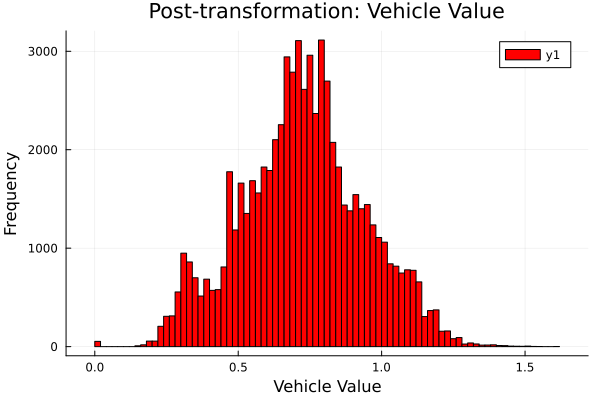

In [9]:
histogram(X[:, 2], xlabel = "Vehicle Value", title = "Post-transformation: Vehicle Value", 
    ylabel = "Frequency", 
    color = "red")

A low-variance filter with a threshold of 0.01 is applied, meaning any feature with a variance below 1%% is removed.

In [10]:
println("Pre low-variance filter: ", size(X, 2))

Pre low-variance filter: 23


In [11]:
X = lowVarianceFilter(X; t=0.01);

In [12]:
println("Post low-variance filter: ", size(X, 2))

Post low-variance filter: 19


We apply SMOTE in order to address class imbalance in the training set:

In [13]:
X_M = Matrix{Float64}(X);
smote_X, smote_y = smote(X_M, y, k = 5, 
    pct_under = 200, pct_over = 100);

In [14]:
smote_Xdf = DataFrame(smote_X, names(X));

In [15]:
mean(smote_y)

0.5

In [16]:
mean(y)

0.06814430558830464

By using `partition()`, we ensure the distribution of out target variable is evenly dispersed:

In [17]:
train, test = partition(eachindex(y), 0.7);
train_X, train_y = smote_X, smote_y |> gpu;
train_Xdf, train_y = smote_Xdf, smote_y;

┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/patrick/.julia/packages/Flux/7nTyc/src/functor.jl:187


We keep a testing set imbalances like original data.

In [18]:
test_X = X_M[test, :];
test_Xdf = X[test, :];
test_y = y[test];

We construct an ANN with two hidden layer of 10 neurons and 6 neurons, respectively. The tanh activation function scales inputs between -1 and 1 and introduces non-linearity.

In [19]:
n_features = size(train_X, 2);
model = Chain(
    Dense(n_features, 10, tanh), 
    Dense(10, 6, tanh), 
    Dense(6, 4, tanh), 
    Dense(4, 1, sigmoid)) |> gpu;
β = Flux.params(model);

ADAM is chosen as the optimiser and MSE the loss function:

In [20]:
δ = Flux.NADAM()
ℓ(x, y) = Flux.Losses.mse(model(x), y)

ℓ (generic function with 1 method)

We train using 5 000 epochs (for demonstrative purposes) and display the loss every N/10 epochs for transparency.

In [21]:
println("Starting training...")
@show ℓ(train_X', train_y')

Starting training...
ℓ(train_X', train_y') = 0.2637811973355906


0.2637811973355906

In [22]:
N = 10_000;

In [23]:
epochs = zeros(N)
for epoch ∈ 1:N
    # shuffle the data
    train_data = [train_X train_y][shuffle(1:end), :]
    train_X = train_data[:, 1:(end-1)]
    train_y = train_data[:, end]
    train_data = [(train_X', train_y')]
    # train the model
    Flux.train!(ℓ, β, train_data, δ)
    epochs[epoch] = ℓ(train_X', train_y')
    # print 10 epochs
    if epoch % (N/10) == 0
        @show epoch
        @show ℓ(train_X', train_y')
    end
end

epoch = 5000
ℓ(train_X', train_y') = 0.21651732458204911
epoch = 10000
ℓ(train_X', train_y') = 0.2138403265052338
epoch = 15000
ℓ(train_X', train_y') = 0.2133479854049435
epoch = 20000
ℓ(train_X', train_y') = 0.21294301730889081
epoch = 25000
ℓ(train_X', train_y') = 0.21271730048477203


LoadError: InterruptException:

In [ ]:
plot(1:N, epochs, xlabel = "Epochs", ylabel = "Loss")

Once trained, our model that generates the predictions assigns a 1 (at least one claim has occured) to all output values from the sigmoid output function greater than 0.5 and zero otherwise (no claim has occured).

In [25]:
predict_NN(x) = model(x) .> 0.5

predict_NN (generic function with 1 method)

Our final model can now be validated on unseen testing data:

In [26]:
CM = confusion_matrix(predict_NN(test_X'), test_y')

┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/patrick/.julia/packages/MLJBase/6ooqv/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    7956     │     235     │
├─────────────┼─────────────┼─────────────┤
│      1      │    10914    │    1252     │
└─────────────┴─────────────┴─────────────┘


In [27]:
@show metrics(confusionMatrix(predict_NN(test_X'), test_y'))

metrics(confusionMatrix(predict_NN(test_X'), test_y')) = (Accuracy = 0.45232598123495604, Precision = 0.42162162162162165, Recall = 0.9713099743621048, F1_Score = 0.5880048778685193)


(Accuracy = 0.45232598123495604,
 Precision = 0.42162162162162165,
 Recall = 0.9713099743621048,
 F1_Score = 0.5880048778685193,)

## Random Forest

In [28]:
using MLJ

In [29]:
train_y = categorical(train_y);

In [30]:
scitype(train_y)

AbstractVector{Multiclass{2}} (alias for AbstractArray{Multiclass{2}, 1})

In [31]:
schema(train_Xdf)

┌──────────────────────────────┬────────────┬─────────┐
│ names                        │ scitypes   │ types   │
├──────────────────────────────┼────────────┼─────────┤
│ Exposure                     │ Continuous │ Float64 │
│ VehValue                     │ Continuous │ Float64 │
│ VehAge.'young cars'          │ Continuous │ Float64 │
│ VehAge.'oldest cars'         │ Continuous │ Float64 │
│ VehAge.'youngest cars'       │ Continuous │ Float64 │
│ VehBody.'Utility'            │ Continuous │ Float64 │
│ VehBody.'Station wagon'      │ Continuous │ Float64 │
│ VehBody.'Hardtop'            │ Continuous │ Float64 │
│ VehBody.'Panel van'          │ Continuous │ Float64 │
│ VehBody.'Sedan'              │ Continuous │ Float64 │
│ VehBody.'Truck'              │ Continuous │ Float64 │
│ VehBody.'Coupe'              │ Continuous │ Float64 │
│ VehBody.'Minibus'            │ Continuous │ Float64 │
│ Gender.'Male'                │ Continuous │ Float64 │
│ DrivAge.'older work. people' │ Continuous │ Fl

In [32]:
first(train_Xdf, 1) |> pretty

┌────────────┬────────────┬─────────────────────┬──────────────────────┬────────────────────────┬───────────────────┬─────────────────────────┬───────────────────┬─────────────────────┬─────────────────┬─────────────────┬─────────────────┬───────────────────┬───────────────┬──────────────────────────────┬─────────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────────┐
│ Exposure   │ VehValue   │ VehAge.'young cars' │ VehAge.'oldest cars' │ VehAge.'youngest cars' │ VehBody.'Utility' │ VehBody.'Station wagon' │ VehBody.'Hardtop' │ VehBody.'Panel van' │ VehBody.'Sedan' │ VehBody.'Truck' │ VehBody.'Coupe' │ VehBody.'Minibus' │ Gender.'Male' │ DrivAge.'older work. people' │ DrivAge.'oldest people' │ DrivAge.'working people' │ DrivAge.'old people' │ DrivAge.'youngest people' │
│ Float64    │ Float64    │ Float64             │ Float64              │ Float64                │ Float64           │ Float64                 │ Float64           │ Float64       

In [33]:
localmodels()

15-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = ConstantRegressor, package_name = MLJModels, ... )
 (name = ContinuousEncoder, package_name = MLJModels, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = DeterministicConstantRegressor, package_name = MLJModels, ... )
 (name = FeatureSelector, package_name = MLJModels

In [34]:
tree = (@load DecisionTreeClassifier pkg=DecisionTree verbosity=0)()

DecisionTreeClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

In [35]:
forest = EnsembleModel(model=tree, n=1_000)

ProbabilisticEnsembleModel(
  model = DecisionTreeClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 0, 
        post_prune = false, 
        merge_purity_threshold = 1.0, 
        display_depth = 5, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  atomic_weights = Float64[], 
  bagging_fraction = 0.8, 
  rng = Random._GLOBAL_RNG(), 
  n = 1000, 
  acceleration = CPU1{Nothing}(nothing), 
  out_of_bag_measure = Any[])

In [36]:
mach = machine(forest, train_Xdf, train_y)

untrained Machine; caches model-specific representations of data
  model: ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …)
  args: 
    1:	Source @185 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @696 ⏎ AbstractVector{Multiclass{2}}


In [37]:
fit!(mach, verbosity=2)

┌ Info: Training machine(ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …).
└ @ MLJBase /home/patrick/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: One hash per new atom trained: 
└ @ MLJEnsembles /home/patrick/.julia/packages/MLJEnsembles/XNwWy/src/ensembles.jl:381


#####

┌ Error: Problem fitting the machine machine(ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …). 
└ @ MLJBase /home/patrick/.julia/packages/MLJBase/6ooqv/src/machines.jl:627
┌ Info: Running type checks... 
└ @ MLJBase /home/patrick/.julia/packages/MLJBase/6ooqv/src/machines.jl:633
┌ Info: Type checks okay. 
└ @ MLJBase /home/patrick/.julia/packages/MLJBase/6ooqv/src/machines.jl:637


LoadError: InterruptException:

In [38]:
evaluate(tree, train_Xdf, train_y,
                resampling=CV(shuffle=true),
                        measures=accuracy,
                        verbosity=0)

LoadError: InterruptException:

In [39]:
rf_predict = predict(mach, test_Xdf)

LoadError: machine(ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …) has not been trained.

In [40]:
fitted_params(mach)

LoadError: machine(ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …) has not been trained. Call `fit!` on the machine, or, if you meant to create a learning network `Node`, use the syntax `node(fitted_params, mach::Machine)`. 

In [41]:
report(mach)

LoadError: machine(ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …) has not been trained. Call `fit!` on the machine, or, if you meant to create a learning network `Node`, use the syntax `node(report, mach::Machine)`. 

In [ ]:
tree_predict = MLJ.predict(tree, test_X);

In [ ]:
function predict_function(model, data)
  data_pred = DataFrame(test_y = MLJ.predict(model, data))
  return data_pred
end

In [ ]:
predict_function(tree, test_X)

In [ ]:
#------------------------------------------------------------------------------
# ShapML setup.
explain = copy(test_Xdf[1:300, :]) # Compute Shapley feature-level predictions for 300 instances.

reference = copy(test_Xdf)  # An optional reference population to compute the baseline prediction.

sample_size = 60  # Number of Monte Carlo samples.
#------------------------------------------------------------------------------
# Compute stochastic Shapley values.
data_shap = ShapML.shap(explain = explain,
                        reference = reference,
                        model = model,
                        predict_function = predict_function,
                        sample_size = sample_size,
                        seed = 1
                        )

show(data_shap, allcols = true)